<a href="https://colab.research.google.com/github/Mailisyorlik/L-D_HOML/blob/main/hands_on_ml_liam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

           Country  GDP per capita (USD)  Life satisfaction
0           Russia          26456.387938                5.8
1           Greece          27287.083401                5.4
2           Turkey          28384.987785                5.5
3           Latvia          29932.493910                5.9
4          Hungary          31007.768407                5.6
5         Portugal          32181.154537                5.4
6           Poland          32238.157259                6.1
7          Estonia          35638.421351                5.7
8            Spain          36215.447591                6.3
9         Slovenia          36547.738956                5.9
10       Lithuania          36732.034744                5.9
11          Israel          38341.307570                7.2
12           Italy          38992.148381                6.0
13  United Kingdom          41627.129269                6.8
14          France          42025.617373                6.5
15     New Zealand          42404.393738

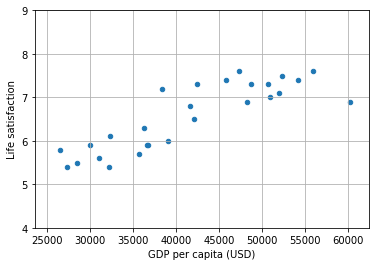

[[6.30165767]]


In [5]:
 #train and runa linear model using scikit learn
#!pip install matplotlib
#!pip install sklearn
#!pip install numpy
#!pip install pandas


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression


#download and prep the data
data_root = "https://github.com/ageron/data/raw/main/"
lifesat = pd.read_csv(data_root + "lifesat/lifesat.csv")
X = lifesat[["GDP per capita (USD)"]].values
y = lifesat[["Life satisfaction"]].values

print(lifesat)

#visualize the data
lifesat.plot(kind = 'scatter', grid = True, x = "GDP per capita (USD)", y = 
             "Life satisfaction")

plt.axis([23_500, 62_500, 4, 9])
plt.show()

#select a linear model
model = LinearRegression()

#train the model
model.fit(X, y)

#make a prediction for cyprus
X_new = [[37_655.2]]
print(model.predict(X_new))







<bound method DataFrame.info of        longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0        -122.23     37.88                41.0        880.0           129.0   
1        -122.22     37.86                21.0       7099.0          1106.0   
2        -122.24     37.85                52.0       1467.0           190.0   
3        -122.25     37.85                52.0       1274.0           235.0   
4        -122.25     37.85                52.0       1627.0           280.0   
...          ...       ...                 ...          ...             ...   
20635    -121.09     39.48                25.0       1665.0           374.0   
20636    -121.21     39.49                18.0        697.0           150.0   
20637    -121.22     39.43                17.0       2254.0           485.0   
20638    -121.32     39.43                18.0       1860.0           409.0   
20639    -121.24     39.37                16.0       2785.0           616.0   

       population  

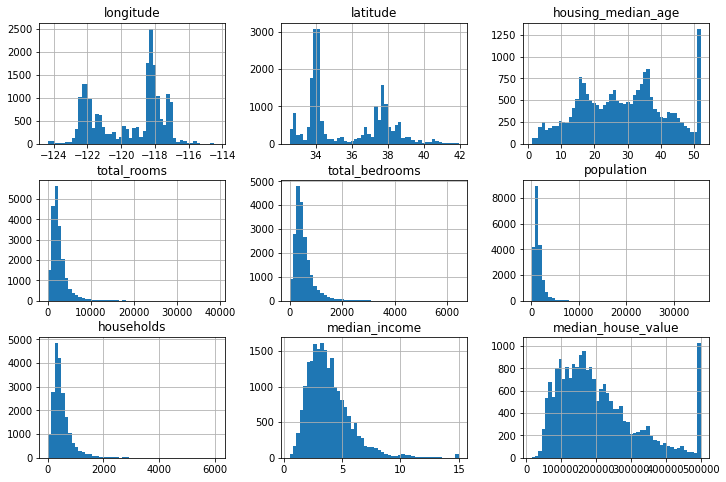

In [6]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request
import matplotlib.pyplot as plt

def load_housing_data():
  tarball_path = Path("datasets/housing.tgz")
  if not tarball_path.is_file():
    Path("datasets").mkdir(parents = True, exist_ok = True)
    url = "https://github.com/ageron/data/raw/main/housing.tgz"
    urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as housing_tarball:
      housing_tarball.extractall(path = "datasets")
  return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

print(housing.info)

housing.hist(bins = 50, figsize = (12, 8))
plt.show()

#worth noting here that median income is not expressed in USD - they repressent roughly tens of thousands of dollars
#housing median age and value were capped
#the histograms are skewed right -> this can make it harder to detect patterns


import numpy as np

def shuffle_and_split_data(data, test_ratio):
  shuffled_indices = np.random.permutation(len(data))
  test_set_size = int(len(data) * test_ratio)
  test_indices = shuffled_indices[:test_set_size:]
  train_indices = shuffled_indices[test_set_size]
  return data.iloc[train_indices], data.iloc[test_indices]


train_set, test_set = shuffle_and_split_data(housing, .2)






---


We now want to determine how to split the data sets, in order to avoid *data snooping* bias. Basically, if we spend too much time looking at the raw data trying to determine what algorithm is the best to use, our brain will pick out patterns and we may make selections that lead to overfitting. 

---

This is pretty simple; pick some % of instances and set them aside (say, 20% in this instance).


In [7]:
from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
  return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
  ids = data[id_column]
  in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
  return data.loc[~in_test_set], data.loc[in_test_set]

housing_with_id = housing.reset_index()
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")



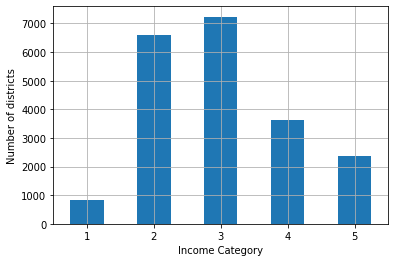

In [8]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size = 0.2, random_state = 42)

housing["income_cat"] = pd.cut(housing["median_income"], bins = [0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels = [1, 2, 3, 4, 5])

housing["income_cat"].value_counts().sort_index().plot.bar(rot = 0, grid = True)
plt.xlabel("Income Category")
plt.ylabel("Number of districts")

plt.show()


It is worth noting that split() yields the training and test set indices, not the data itself

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 42)
strat_splits = []

for train_index, test_index in splitter.split(housing, housing["income_cat"]):
  strat_train_set_n = housing.iloc[train_index]
  strat_test_set_n = housing.iloc[test_index]
  strat_splits.append([strat_train_set_n, strat_test_set_n])

strat_train_set, strat_test_set = strat_splits[0]

strat_train_set, strat_test_set = train_test_split(housing, test_size = 0.2, stratify = housing["income_cat"], random_state = 42)

#lets see if this works as expected by looking at the proportions of income categories in the test set

strat_test_set["income_cat"].value_counts()/len(strat_test_set)

#now we want to drop the income_cat column, since we will not be using it again
for set_ in (strat_train_set, strat_test_set):
  set_.drop("income_cat", axis = 1, inplace = True)

  

Now let's make a copy of the training set in full since we will experimenting but do not want the experiments to interfere with the original dataset

In [10]:
housing = strat_train_set.copy()

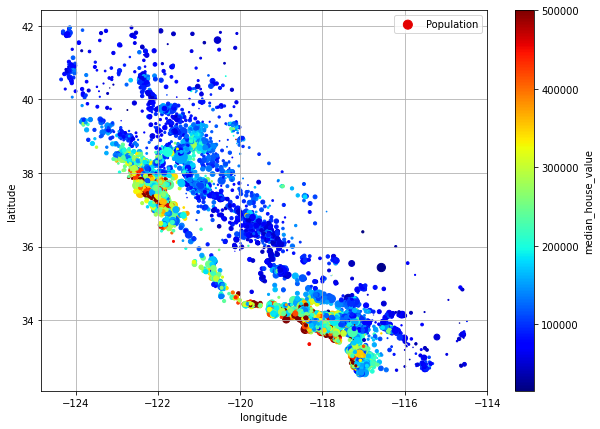

In [11]:
#now let's plot the geopgraphic data
housing.plot(kind = "scatter", x = "longitude", y = "latitude", grid = True,
             s = housing["population"]/100, label = "Population", c = "median_house_value", cmap = "jet",
             colorbar = True, legend = True, sharex = False, figsize = (10,7))
plt.show()



This graph is more colorful because of the cmap parameter

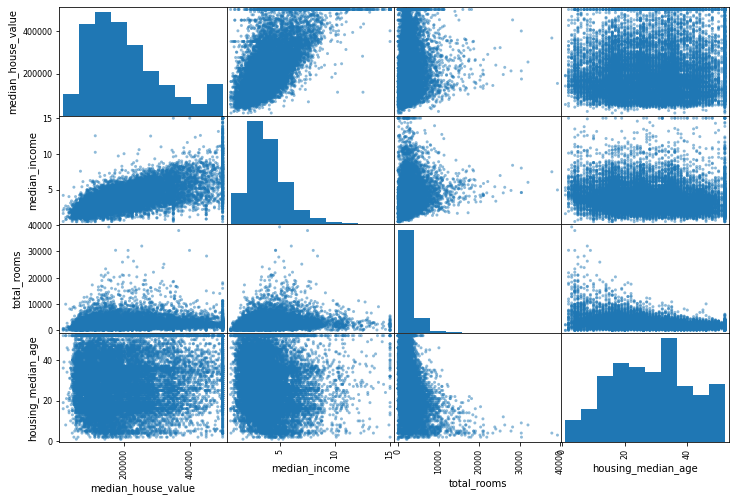

In [12]:
#now we are going to look for correlation between attributes, since the dataset is not too large

from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]

scatter_matrix(housing[attributes], figsize = (12, 8))

plt.show()

looks like the most promising path here is to predict the median house value via median income, so let's zoom in on that plot

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

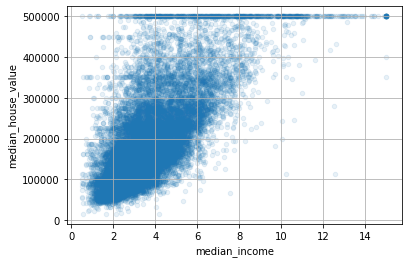

In [13]:
housing.plot(kind = "scatter", x = "median_income", y = "median_house_value", alpha = 0.1, grid = True)

so this is probably a pretty strong relationship. Something worth noting though, is that this kind of correlation only captures linear relationships. 

let's do some experimenting with combining attributes


In [14]:
housing["rooms_per_house"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["people_per_house"] = housing["population"]/housing["households"]

print(housing["rooms_per_house"])
print(housing["bedrooms_ratio"])
print(housing["people_per_house"])

13096    3.211799
14973    5.504202
3785     5.334975
14689    5.351282
20507    3.725256
           ...   
14207    4.277247
13105    5.535714
19301    5.157895
19121    4.511933
19888    2.033019
Name: rooms_per_house, Length: 16512, dtype: float64
13096    0.335742
14973    0.180153
3785     0.200369
14689    0.203881
20507    0.277371
           ...   
14207    0.266875
13105    0.201019
19301    0.197704
19121    0.230891
19888    0.452436
Name: bedrooms_ratio, Length: 16512, dtype: float64
13096    1.524178
14973    1.865546
3785     2.768473
14689    2.365385
20507    1.631399
           ...   
14207    1.793499
13105    2.667293
19301    3.702632
19121    2.058473
19888    3.216981
Name: people_per_house, Length: 16512, dtype: float64


Now it is time to prep the data for an ML algorithm

We will revert to the clean training dataset

In [15]:
housing = strat_train_set.drop("median_house_value", axis = 1)
housing_labels = strat_train_set["median_house_value"].copy()

Now we will clean the data. We have a few options to deal with missing features. 

1.) We can get rid of the corresponding districts

2.) We can get rid of the whole attribute

3.) We can set the missing values to some other value (zero, the median, etc) -> this is called imputation

We can accomplish these via Pandas DataFrame's dropna(), drop(), and fillna()

In [16]:
#we opt for # 3, using Sklearns SimpleImputer class

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy = "median")

#since the median can only be computed on numerical attributes, we need to create a copy of the
#data with only the numerical attributes, so we want to drop the text attribute "ocean proximity"

housing_num = housing.select_dtypes(include = [np.number])

imputer.fit(housing_num)

imputer.statistics_
housing_num.median().values

#now we can use this "trained imputer" to transform the training set by replacing missing values with learned medians
X = imputer.transform(housing_num)


We need a way to encode categorical variables as quantities. In this instance, convert ocean proximity to a one-hot categorical encoding. 

In [17]:
housing_tr = pd.DataFrame(X, columns = housing_num.columns, index = housing_num.index)

housing_cat = housing[["ocean_proximity"]]
housing_cat.head(80)
#something is wrong with this dataset since they are all showing the same value

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
...,...
20482,INLAND
1910,INLAND
4790,<1H OCEAN
4683,INLAND


We are going to use the OrdinalEncoder class from Sklearn to convert a categorical attribute to a numerical one. 

In [18]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:8]

ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

We are going to use one hot encoding to prevent the algorithm from learning non-existent ordinal patterns. 

In [19]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

Pandas has a function called get_dummies(), which also converts each categorical feature into one-hot representatino, with one binary feature per category. 


In [20]:
df_test = pd.DataFrame({"ocean_proximity":["INLAND", "NEAR BAY"]})
pd.get_dummies(df_test)

,ocean_proximity_INLAND,ocean_proximity_NEAR BAY
0,1,0
1,0,1


note: the benefit of OneHotEncoder is that is remembers which categories it was trained one. This is essential for model consistency in production.

In [21]:
cat_encoder.transform(df_test)
#see notes on page 74

#when you fit any scikit learn estimator using a dataframe, the estimator stores the column names in the feature_names_in_ attribute
#scitkit learn then ensures that any dataframe fed to this estimator after that has the same column names
#transformers also provide a get_feature_names_out() method you can use to build a dataframe around the transformers output

cat_encoder.feature_names_in_



array(['ocean_proximity'], dtype=object)

**Feature scaling and transformation:**

ML algos do not perform well when features have different scale. In order to get all attributes on the same scale, we have two options: standardization and min max scaling/normalization.

Normalization: for each attribute, the values are shifted so that they fall in a range between 0 and 1. 

Standardization: substract the mean value then divides the result by the standard deviation. Standardized values are not restricted to a range of 0-1. It is also less affected by outliers. 

In [22]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

Two options for handling heavy tailed features (i.e. when values far from the mean are not exponentially rare). In order to avoid issues when training (what kind of issues, why does this matter), you can 

1.) transform the distribution to shrink the heavy tail (e.g. by taking the log of the distribution).

2.) Bucketize the feature. This means chopping the distribution into roughly equal size buckets, and then replacing each feature value with the index of the bucket it belongs to. 

For features with multimodal distributions (i.e. with two or more clear peaks, called modes), such as the housing_median_age feature, it can be helpful to bucketize but that also means that we treat the bucket IDs as categories, rather than as numerical values. 

Yet another option is to add a feature for each of the modes, representing the similarity between the housing median age and that particular mode. The similarity measure is typically computed using a radial basis function. The most common is a Gaussian RBF, whose output value decays exponentially as the input value moves away from the fixed point. FOr instance, the gaussian RBD for the similarity between the housing age **x** and 35 is given by the equation exp(-y(x-35)^2). The gamma (y) hyperparameter determines how quickly the similarity measure decays as x moves away from 35. Using Scitkit-Learns rbf_kernel() function, you can create a new gaussian RBF feature measuring the similarity between the housing median age and 35.




In [23]:
from sklearn.metrics.pairwise import rbf_kernel 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma = 0.1)

target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())

model = LinearRegression()
model.fit(housing[["median_income"]], scaled_labels)
some_new_data = housing[["median_income"]].iloc[:5] #pretend this is new data

scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)

There is a simpler way to do this by using a TransformedTargetRegressor. We need to construct it, giving it to the regression model and the label transformer, then fit it on the training set, using the original unscaled labels. It will automatically use the transformer to scale the labels and train the regression model on the resulting scaled labels.

In [24]:
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(), transformer = StandardScaler())
model.fit(housing[["median_income"]], housing_labels)
predictions = model.predict(some_new_data) 

Let's now write a custom transformer for our own purposes. For those which do not require training, we can just write functions that take numpy arrays as input and output a transformed array. Let's create a log transformer and apply it to the population feature. 

In [25]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func = np.exp) #inverse func arg is optioinal. Really only would apply if we 
#decided to use the transformer 
log_pop = log_transformer.transform(housing[["population"]])

rbf_transformer = FunctionTransformer(rbf_kernel, kw_args = dict(Y=[[35.]], gamma = 0.1))
age_simil_35 = rbf_transformer.transform(housing[["housing_median_age"]])

sf_coords = 37.7749, -122.41
sf_transformer = FunctionTransformer(rbf_kernel, kw_args = dict(Y = [sf_coords], gamma = 0.1))
sf_simil = sf_transformer.transform(housing[["latitude", 'longitude']])

ratio_transformer = FunctionTransformer(lambda X: X[:, [0]] / X[:,[1]])
ratio_transformer.transform(np.array([[1., 2.], [3., 4.]]))



array([[0.5 ],
       [0.75]])

now what if i want to make my transfomer trainable? For instance, if I wanted to have the transformer learn some parameters in the fit() method and use them in the transform() method? We would need to write a custom class. Example below is a custom transformer that acts much like StandardScaler

In [26]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):
  def __init__(self, with_mean = True):
    self.with_mean = with_mean
  
  def fit(self, X, y = None):
    X = check_array(X)
    self.mean_ = X.mean(axis = 0)
    self.scale_ = X.std(axis = 0)
    self.n_features_in_ = X.shape[0]
  
  def transform(self, X):
    check_is_fitted(self)
    X = check_array(X)
    assert self.n_features_in_ == X.shape[1]
    if self.with_mean:
      X = X - self.mean_
    return X / self.scale_


#this implementation is not complete - all estimators should set feature_names_in_ in the fit() method when they are passed a dataframe

#

A custom transformer can (and often does) use other estimators in its implementation

The following code demonstrates custom transformer tat uses a Kmeans clusterer in the fit() method to identify the main clusters in the training data, and then uses the rbf_kernel() in the transform() method to measure how similar each sample is to its cluster center




In [27]:
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
  def __init__(self, n_clusters = 10, gamma = 1.0, random_state = None):
    self.n_clusters = n_clusters
    self.gamma = gamma
    self.random_state = random_state

  def fit(self, X, y = None, sample_weight = None):
    self.kmeans_ = KMeans(self.n_clusters, random_state = self.random_state)
    self.kmeans_.fit(X, sample_weight= sample_weight)
    return self #dont forget this part!
  
  def transform(self, X):
    return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma = self.gamma)
  
  def get_featyre_names_out(self, names = None):
    return [f"Cluster {i} similarity" for i in range(self.n_clusters)]


In [28]:
cluster_simil = ClusterSimilarity(n_clusters = 10, gamma = 1., random_state = 42)
similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]], sample_weight = housing_labels)
similarities[:3].round(2)


array([[0.  , 0.14, 0.  , 0.  , 0.  , 0.08, 0.  , 0.99, 0.  , 0.6 ],
       [0.63, 0.  , 0.99, 0.  , 0.  , 0.  , 0.04, 0.  , 0.11, 0.  ],
       [0.  , 0.29, 0.  , 0.  , 0.01, 0.44, 0.  , 0.7 , 0.  , 0.3 ]])

In [29]:
#as you can see, there are many data transformation steps that need to be executed in the right order
#scitkit learn provides the Pipeline class to help manage this sequence
#the example here is a small pipeline for handling numerical attributes which will first impute then scale features
import sklearn
from sklearn.pipeline import Pipeline
sklearn.set_config(display = "diagram")

num_pipeline = Pipeline([("impute", SimpleImputer(strategy = "median")),
                         ("standardize", StandardScaler()), ])
num_pipeline

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('standardize', StandardScaler())])

The Pipeline constructor takes a list of name/estimator pairs (2 - tuples) defining a sequence of steps. The names can be anything as long as they are unique and do not contain double underscores. The estimators must all be transformers except for the last, which can be either transformer, predictor, or any other type of estimator. 

Now let's call the pipeline's fit_transform() method and look at the output's first two rows, rounded to two decimal places:

In [30]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)

#now if we want to recover a nice dataframe, we can use the pipeline's get feature_names_out() method

#df_housing_num_prepared = pd.DataFrame(housing_num_prepared, columns = num_pipeline[:-1].get_feature_names_out(), index = housing_num.index)


array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17]])

Pipelines support indexing: for example, pipeline[1] returns the second estimator in the pipeline, and pipeline[:-1] returns a Pipeline object containing all but the last estimator. 

Let's now, for the sake of extensibility, create a single transformer that can handle all columns. We can use ColumnTransformer. 

In [34]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population",
               "households", "median_income"]

cat_attribs = ["ocean_proximity"]

cat_pipeline = make_pipeline(SimpleImputer(strategy = "most_frequent"), OneHotEncoder(handle_unknown = "ignore"))

preprocessing = ColumnTransformer([("num", num_pipeline, num_attribs), ("cat", cat_pipeline, cat_attribs),])

housing_prepared = preprocessing.fit_transform(housing)




Now we have built a preprocessing pipeline that takes the entire
training set and applies each transformer to the appropriate 
columns and then concatenates the transformed columns horizontally. 
Transformers must never change the numebr of rows



In [49]:
from sklearn.compose import make_column_selector, make_column_transformer




def column_ratio(X):
  return X[:, [0]]/ X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
  return ["ratio"] #feature names out



def ratio_pipeline():
  return make_pipeline(
      SimpleImputer(strategy = "median"),
      FunctionTransformer(column_ratio, feature_names_out = ratio_name),
      StandardScaler())

log_pipeline = make_pipeline(
    SimpleImputer(strategy = "median"),
    FunctionTransformer(np.log, feature_names_out = "one-to-one"),
    StandardScaler())
cluster_simil = ClusterSimilarity(n_clusters = 10, gamma = 1, random_state = 42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy = "median"), StandardScaler())

preprocessing = ColumnTransformer([
    ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
    ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
    ("people_per_house", ratio_pipeline(), ["population", "households"]),
    ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                           "households", "median_income"]),
    ("geo", cluster_simil, ["latitude", "longitude"]),
    ("cat", cat_pipeline, make_column_selector(dtype_include = object)),
], 
remainder = default_num_pipeline)


#if we run this, it outputs a numpy array with all 24 features


TypeError: ignored